In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy
from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator
import pynextsim.lib as nsl
from pyproj import Proj

dst_proj = Proj(proj='stere', a=6378.273e3, b=6378.273e3*np.sqrt(1-0.081816153**2), lon_0=-45., lat_0=90., lat_ts=60.)

plot_crs = cartopy.crs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=60)

def gen_uniform_grid(xstart, xend, ystart, yend, dx):
    RE = 6378273.
    xcoord = np.arange(xstart, xend, dx*1e3)
    ycoord = np.arange(ystart, yend, dx*1e3)
    y, x = np.meshgrid(ycoord, xcoord)
    return x, y

def pwrspec2d(field):
    nx, ny = field.shape
    FT = np.zeros((nx, ny), dtype=complex)
    nupx = int(np.ceil((nx+1)/2))
    nupy = int(np.ceil((ny+1)/2))
    nup = max(nupx, nupy)
    wnx = fft_wn(nx)
    wny = fft_wn(ny)
    ky, kx = np.meshgrid(wny, wnx)
    k2d = np.sqrt((kx*(nup/nupx))**2 + (ky*(nup/nupy))**2)
    FT = np.fft.fft2(field) 
    P = (np.abs(FT)/nx/ny)**2
    wn = np.arange(0.0, nup)
    pwr = np.zeros((nup))
    for w in range(nup):
        pwr[w] = np.sum(P[np.where(np.ceil(k2d)==w)])
    return wn, pwr

##utility functions: convert between state and spectral spaces
def grid2spec(f):
    ni, nj = (f.shape[0], f.shape[1])
    return np.fft.fft2(f, axes=(0, 1))

def spec2grid(fk):
    ni, nj = (fk.shape[0], fk.shape[1])
    return np.real(np.fft.ifft2(fk, axes=(0, 1)))

##generate wavenumber sequence for fft results
def fft_wn(n):
    nup = int(np.ceil((n+1)/2))
    if n%2 == 0:
        wn = np.concatenate((np.arange(0, nup), np.arange(2-nup, 0)))
    else:
        wn = np.concatenate((np.arange(0, nup), np.arange(1-nup, 0)))
    return wn

##generate meshgrid wavenumber for input field x
## the first two dimensions are horizontal (i, j)
def get_wn(x):
    dims = x.shape
    n = dims[0]
    ii = fft_wn(dims[0])
    jj = fft_wn(dims[1])
    wni = np.expand_dims(ii, 1)
    wni = np.repeat(wni, dims[1], axis=1)
    wnj = np.expand_dims(jj, 0)
    wnj = np.repeat(wnj, dims[0], axis=0)
    for d in range(2, len(dims)):  ##extra dimensions
        wni = np.expand_dims(wni, d)
        wni = np.repeat(wni, dims[d], axis=d)
        wnj = np.expand_dims(wnj, d)
        wnj = np.repeat(wnj, dims[d], axis=d)
    return wni, wnj

##scale decomposition
def lowpass_resp(Kh, k1, k2):
    r = np.zeros(Kh.shape)
    r[np.where(Kh<k1)] = 1.0
    r[np.where(Kh>k2)] = 0.0
    ind = np.where(np.logical_and(Kh>=k1, Kh<=k2))
    r[ind] = np.cos((Kh[ind] - k1)*(0.5*np.pi/(k2 - k1)))**2
    return r


def get_scale(x, kr, s):
    xk = grid2spec(x)
    xkout = xk.copy()
    ns = len(kr)
    if ns > 1:
        kx, ky = get_wn(x)
        Kh = np.sqrt(kx**2 + ky**2)
        if s == 0:
            xkout = xk * lowpass_resp(Kh, kr[s], kr[s+1])
        if s == ns-1:
            xkout = xk * (1 - lowpass_resp(Kh, kr[s-1], kr[s]))
        if s > 0 and s < ns-1:
            xkout = xk * (lowpass_resp(Kh, kr[s], kr[s+1]) - lowpass_resp(Kh, kr[s-1], kr[s]))
    return spec2grid(xkout)


In [2]:
import datetime
t = datetime.datetime.strptime('202001010000', '%Y%m%d%H%M')

In [3]:
##ECMWF forecast
f0 = Dataset('/Users/yueng/mnt/nersc/sim/data/ECMWF_forecast_arctic/{:04d}/{:02d}/ec2_start{:04d}{:02d}{:02d}.nc'.format(t.year, t.month, t.year, t.month, t.day))
u0 = f0['10U'][0, :, :]
v0 = f0['10V'][0, :, :]
latitude = f0['lat'][:]
longitude = f0['lon'][:]
lon, lat = np.meshgrid(longitude, latitude)
tmp = plot_crs.transform_points(cartopy.crs.PlateCarree(), lon, lat)
x1 = tmp[:,:,0]
y1 = tmp[:,:,1]
u1, v1 = nsl.transform_vectors(dst_proj, x1, y1, u0, v0, fill_polar_hole=True)

In [8]:
##regrid to arctic domain
dx = 20 #km
x, y = gen_uniform_grid(-2.5e6, 3e6, -2e6, 2.5e6, dx)
igi = IrregularGridInterpolator(x1, y1, x, y)
u = igi.interp_field(u1)
v = igi.interp_field(v1)
L = np.maximum(*x.shape)*dx ##domain size

In [14]:
##AROME forecast in a smaller domain
fs = Dataset("https://thredds.met.no/thredds/dodsC/aromearcticarchive/{:04d}/{:02d}/{:02d}/arome_arctic_full_2_5km_{:04d}{:02d}{:02d}T{:02d}Z.nc".format(t.year, t.month, t.day, t.year, t.month, t.day, t.hour))
lv = 0
bn = 0
lats = fs['latitude'][bn:-bn-1, bn:-bn-1]
lons = fs['longitude'][bn:-bn-1, bn:-bn-1]
us = fs['x_wind_10m'][0, lv, bn:-bn-1, bn:-bn-1]
vs = fs['y_wind_10m'][0, lv, bn:-bn-1, bn:-bn-1]

tmp = plot_crs.transform_points(cartopy.crs.PlateCarree(), lons, lats)
xs = tmp[:,:,0]
ys = tmp[:,:,1]

dxs = 2.5
Ls = np.maximum(*xs.shape)*dxs

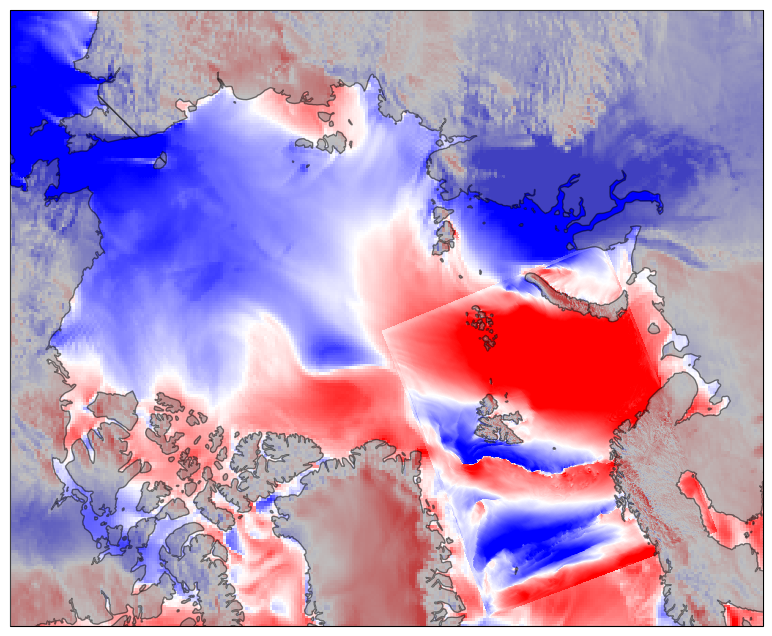

In [15]:
##plot two forecasts together
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': plot_crs})
im = ax.pcolor(x, y, u, vmin=-10, vmax=10, cmap='bwr')
im = ax.pcolor(xs, ys, us, vmin=-10, vmax=10, cmap='bwr')
ax.add_feature(cartopy.feature.LAND, facecolor='gray', edgecolor='black', zorder=10, alpha=0.5)

Text(0.5, 0, 'wavelength (km)')

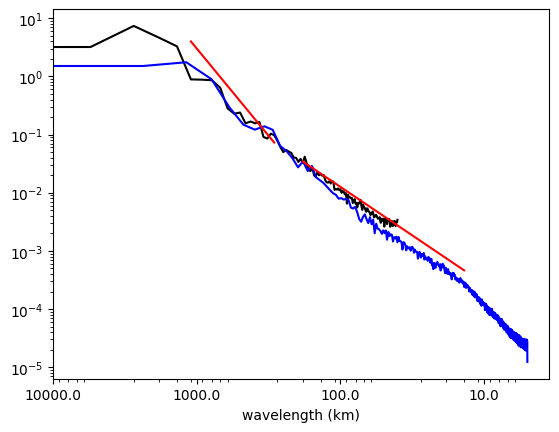

In [16]:
##kinetic energy spectra for the forecasts

fig, ax = plt.subplots(1, 1)

wn, pwr_u = pwrspec2d(u[:, :])
wn, pwr_v = pwrspec2d(v[:, :])
ax.loglog(wn, 0.5*(pwr_u+pwr_v), 'k')

us[np.where(np.isnan(us))] = 0.
vs[np.where(np.isnan(vs))] = 0.
wn, pwr_us = pwrspec2d(us[:, :])
wn, pwr_vs = pwrspec2d(vs[:, :])

sf = L/Ls
ax.loglog(wn*sf, 0.5*(pwr_us+pwr_vs)/sf/sf, 'b')

##ref lines
wn1 = np.arange(5., 20.)
ax.loglog(wn1, 5e2*wn1**-3, 'r')
wn2 = np.arange(30., 400.)
ax.loglog(wn2, 1e1*wn2**(-5/3), 'r')

wl = np.array([1e4, 1e3, 1e2, 1e1])
ax.set_xticks(L/wl)
ax.set_xticklabels(wl)
ax.set_xlabel('wavelength (km)')

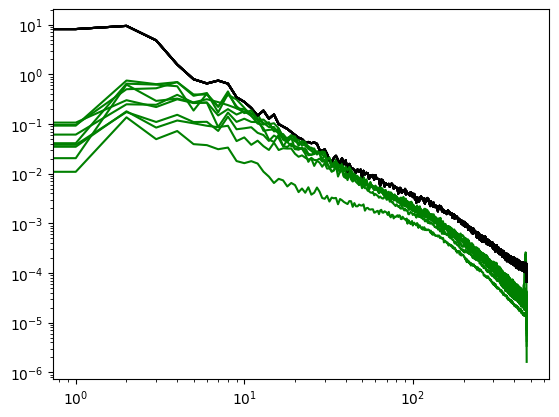

In [27]:
###error KE spectra w.r.t. forecast lead time
fig, ax = plt.subplots(1, 1)

for d in range(1, 10):
    dt = datetime.timedelta(hours=d*6)
    dt_in_file = datetime.timedelta(hours=1)
    t1 = t - dt
    fs2 = Dataset("https://thredds.met.no/thredds/dodsC/aromearcticarchive/{:04d}/{:02d}/{:02d}/arome_arctic_full_2_5km_{:04d}{:02d}{:02d}T{:02d}Z.nc".format(t1.year, t1.month, t1.day, t1.year, t1.month, t1.day, t1.hour))
    t_index = int(dt/dt_in_file)
    us_err = fs2['x_wind_10m'][t_index, lv, bn:-bn-1, bn:-bn-1] - us
    vs_err = fs2['y_wind_10m'][t_index, lv, bn:-bn-1, bn:-bn-1] - vs

    wn, pwr_us = pwrspec2d(us)
    wn, pwr_vs = pwrspec2d(vs)
    ax.loglog(wn, 0.5*(pwr_us+pwr_vs), 'k')

    wn, pwr_us = pwrspec2d(us_err)
    wn, pwr_vs = pwrspec2d(vs_err)
    ax.loglog(wn, 0.5*(pwr_us+pwr_vs), 'g')

In [ ]:
###visualize scale component

krange = (10, 60)
s = 1
us[np.where(np.isnan(us))] = 0.
vs[np.where(np.isnan(vs))] = 0.
us_err[np.where(np.isnan(us_err))] = 0.
vs_err[np.where(np.isnan(vs_err))] = 0.
us_s = get_scale(us, krange, s)
vs_s = get_scale(vs, krange, s)
us_err_s = get_scale(us_err, krange, s)
vs_err_s = get_scale(vs_err, krange, s)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': plot_crs})

ax[0].pcolor(xs, ys, us_s, vmin=-10, vmax=10, cmap='bwr')
ax[1].pcolor(xs, ys, us_err_s, vmin=-10, vmax=10, cmap='bwr')

for i in range(2):
    ax[i].add_feature(cartopy.feature.LAND, facecolor='white', edgecolor='black', zorder=10, alpha=0.5)


0
3
6
9
12


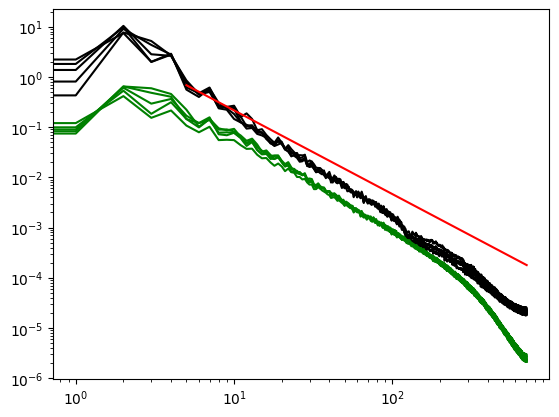

In [29]:
###check error growth from the ensemble spread
##there is almost no error growth??

f = Dataset("/Users/yueng/mnt/nersc/sim/data/EC2_AROME_ENSEMBLE/ec2_arome_blended_ensemble_20180310.nc")

fig, ax = plt.subplots(1, 1)
late = f['latitude'][:, :]
lone = f['longitude'][:, :]
tmp = plot_crs.transform_points(cartopy.crs.PlateCarree(), lone, late)
xe = tmp[:,:,0]
ye = tmp[:,:,1]

for t_index in range(0, 15, 3):
    print(t_index)
    ue = f['x_wind_10m'][t_index, :, :, :]
    ve = f['y_wind_10m'][t_index, :, :, :]
    uem = np.mean(ue, axis=0)
    vem = np.mean(ve, axis=0)
    nens, ny, nx = ue.shape

    wn, pwr_ue = pwrspec2d(uem[:, :])
    wn, pwr_ve = pwrspec2d(vem[:, :])
    ax.loglog(wn, 0.5*(pwr_ue+pwr_ve), 'k')

    sprd_u = pwr_ue; sprd_v = pwr_ve
    for m in range(nens-1):
        wn, pwr_up = pwrspec2d(ue[m, :, :] - ue[m+1, :, :])
        wn, pwr_vp = pwrspec2d(ve[m, :, :] - ve[m+1, :, :])
        sprd_u += pwr_up
        sprd_v += pwr_vp
    sprd_u = sprd_u/(nens-1)/2
    sprd_v = sprd_v/(nens-1)/2
    ax.loglog(wn, 0.5*(sprd_u+sprd_v), 'g')

ax.loglog(wn[5:], 1e1*wn[5:]**(-5/3), 'r')